This IPython Notebook is intended to validate the parameters in the C5G7-TD Benchmark specification by calculating them using the provided isotopic data. The data to be validated includes:

* 7-energy-group Transport, Absorption, Capture, Velocity, and Scatter matrix for each material.
* Fission, Nu, and Chi for each fissile material.
* 8-delayed-group delayed neutron fractions, precursor decay constants, and delayed neutron spectra for each fuel material.

## Generate Input Files

In [1]:
import math
import pickle
import matplotlib

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import openmc
import openmc.mgxs
import openmc.plotter

from geometry import materials, surfaces, universes, cells, lattices, geometry
from mgxs_lib import mgxs_data

%matplotlib inline

We will start by exporting the geometry and materials files to xml.

In [2]:
# Create the materials file
materials_file = openmc.Materials(geometry.get_all_materials())
materials_file.export_to_xml()

# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we can define simulation parameters. In this case, we will use 100 inactive batches and 100 active batches each with 5000 particles.

In [3]:
# OpenMC simulation parameters
batches = 200
inactive = 100
particles = 1000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-32.13, -10.71, -64.26, 10.71,  32.13,  64.26]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

settings_file.entropy_lower_left  = bounds[:3]
settings_file.entropy_upper_right = bounds[3:]
settings_file.entropy_dimension   = [34,34,1]

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a `Plots` file that we can use to verify that our geometry model was created successfully.

In [4]:
plots = {}

# Instantiate a Plot
plots['materialx-xy'] = openmc.Plot()
plots['materialx-xy'].filename = 'materials-xy'
plots['materialx-xy'].origin = [0., 0., 0.]
plots['materialx-xy'].width  = [64.26, 64.26]
plots['materialx-xy'].pixels = [500, 500]
plots['materialx-xy'].color = 'mat'
plots['materialx-xy'].basis = 'xy'

plots['materialx-xz'] = openmc.Plot()
plots['materialx-xz'].filename = 'materials-xz'
plots['materialx-xz'].origin = [0., 0., 0.]
plots['materialx-xz'].width = [64.26, 171.36]
plots['materialx-xz'].pixels = [500, 500]
plots['materialx-xz'].color = 'mat'
plots['materialx-xz'].basis = 'xz'

# Create the plots file
plot_file = openmc.Plots(plots.values())
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [5]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

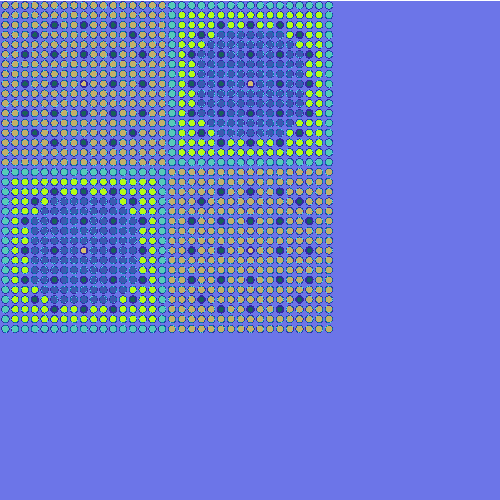

In [6]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have our quarter core model of the C5G7 geometry.

## Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define the ANL and WIMS-D 7-group structures using the built-in `EnergyGroups` class.

In [7]:
# Instantiate a 2-group EnergyGroups object
ANL_groups = openmc.mgxs.EnergyGroups()
ANL_groups.group_edges = [0., 0.13, 0.63, 4.1, 55.6, 9.2e3, 1.36e6, 2.0e7]

WIMS_groups = openmc.mgxs.EnergyGroups()
WIMS_groups.group_edges = [0., 0.14, 0.625, 4.0, 48.052, 9.118e3, 1.353e6, 2.0e7]

Next, we will instantiate an `openmc.mgxs.Library` for the energy groups with our the C5G7 geometry.

In [8]:
# Initialize 7-group MGXS Libraries for the ANL and WIMS group structures
ANL_lib = openmc.mgxs.Library(geometry)
ANL_lib.energy_groups = ANL_groups
ANL_lib.num_delayed_groups = 8

WIMS_lib = openmc.mgxs.Library(geometry)
WIMS_lib.energy_groups = WIMS_groups
WIMS_lib.num_delayed_groups = 8

Now, we must specify to the `Library` which types of cross sections to compute. In particular, the following are the multi-group cross section `MGXS` subclasses that are mapped to string codes accepted by the `Library` class:

* `TotalXS` (`"total"`)
* `TransportXS` (`"transport"`)
* `NuTransportXS` (`"nu-transport"`)
* `AbsorptionXS` (`"absorption"`)
* `CaptureXS` (`"capture"`)
* `FissionXS` (`"fission"`)
* `NuFissionXS` (`"nu-fission"`)
* `KappaFissionXS` (`"kappa-fission"`)
* `ScatterXS` (`"scatter"`)
* `NuScatterXS` (`"nu-scatter"`)
* `ScatterMatrixXS` (`"scatter matrix"`)
* `NuScatterMatrixXS` (`"nu-scatter matrix"`)
* `Chi` (`"chi"`)
* `ChiPrompt` (`"chi prompt"`)
* `InverseVelocity` (`"inverse-velocity"`)
* `PromptNuFissionXS` (`"prompt-nu-fission"`)
* `DelayedNuFissionXS` (`"delayed-nu-fission"`)
* `ChiDelayed` (`"chi-delayed"`)
* `Beta` (`"beta"`)

In this case, we just want to compare the `"transport"`, `'"fission"`, `"scatter matrix"`, `'"nu"'`, `'"capture"'`, `'"velocity"'`, `"chi"`, and `'"absorption"'` for each material. OpenMC doesn't support direction computing the nu and velocity, so these will be computed using tally arithmetic using the `'"nu-fission"'` and `'"fission"'` and `'"inverse-velocity"'` tallies, respectively.

**Note**: A variety of different approximate transport-corrected total multi-group cross sections (and corresponding scattering matrices) can be found in the literature. At the present time, the `openmc.mgxs` module only supports the `"P0"` transport correction. This correction can be turned on and off through the boolean `Library.correction` property which may take values of `"P0"` (default) or `None`.

In [9]:
# Specify multi-group cross section types to compute
ANL_lib.mgxs_types = ['transport', 'nu-fission', 'fission', 'scatter matrix', 'chi', 'capture', 'inverse-velocity', 'absorption', 'chi-delayed', 'beta', 'delayed-nu-fission', 'decay-rate']
WIMS_lib.mgxs_types = ['transport', 'nu-fission', 'fission', 'scatter matrix', 'chi', 'capture', 'inverse-velocity', 'absorption', 'chi-delayed', 'beta', 'delayed-nu-fission', 'decay-rate']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports `"material"`, `"cell"`, `"universe"`, and `"mesh"` domain types. We will use a `"material"` domain type here to compute cross sections in each of the cells in the material.

**Note:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell or universe) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property. In our case, we wish to compute multi-group cross sections in each and every cell since they will be needed in our downstream OpenMOC calculation on the identical combinatorial geometry mesh.

In [10]:
# Specify a "cell" domain type for the cross section tally filters
ANL_lib.domain_type = 'cell'
WIMS_lib.domain_type = 'cell'

# Specify the cell domains over which to compute multi-group cross sections
ANL_lib.domains = geometry.get_all_material_cells()
WIMS_lib.domains = geometry.get_all_material_cells()

We can easily instruct the `Library` to compute multi-group cross sections on a nuclide-by-nuclide basis with the boolean `Library.by_nuclide` property. By default, `by_nuclide` is set to `False`, but we will set it to `True` here.

In [11]:
# Compute cross sections on a nuclide-by-nuclide basis
ANL_lib.by_nuclide = False
WIMS_lib.by_nuclide = False

Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain and nuclide.

In [12]:
# Construct all tallies needed for the multi-group cross section library
ANL_lib.build_library()
WIMS_lib.build_library()

The tallies can now be export to a "tallies.xml" input file for OpenMC. 

**NOTE**: At this point the `Library` has constructed nearly 100 distinct `Tally` objects. The overhead to tally in OpenMC scales as $O(N)$ for $N$ tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart *merging* of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` paramter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [13]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
ANL_lib.add_to_tallies_file(tallies_file, merge=True)
WIMS_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a kappa-fission tally to plot the axially-integrated pin powers.

In [14]:
# Create pin cell mesh 
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [51, 51]
mesh.lower_left  = [-32.13, -32.13]
mesh.upper_right = [ 32.13,  32.13]
pin_cell_mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='kappa-fission')
tally.filters = [pin_cell_mesh_filter]
tally.scores = ['kappa-fission']

# Add tally to collection
#tallies_file.append(tally)

In [15]:
# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

In [16]:
# Run OpenMC
openmc.run(mpi_procs=4)


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [17]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.200.h5')

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [18]:
# Initialize MGXS Library with OpenMC statepoint data
ANL_lib.load_from_statepoint(sp)
WIMS_lib.load_from_statepoint(sp)

Voila! Our multi-group cross sections are now ready to rock 'n roll!

## Comparing the cross sections

Now that we have computed and extracted the multi-group cross sections, we want to compare them with the values in the benchmark specification. First, we will extract the fission cross sections from the materials and compare them with both the benchmark values and the continuous energy cross sections.

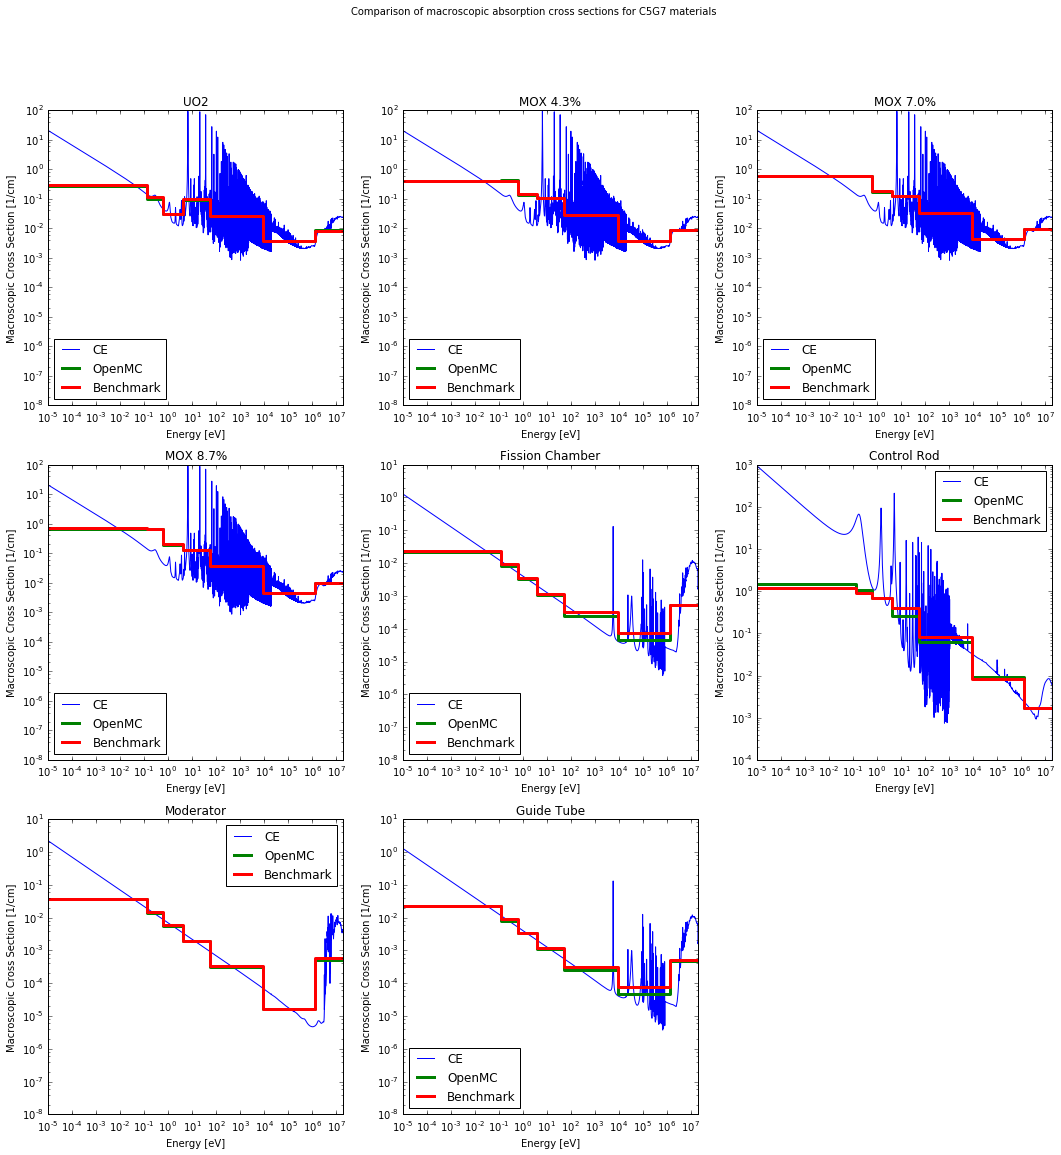

In [21]:
xs = 'absorption'
xs_cells = ['UO2', 'MOX 4.3%', 'MOX 7.0%', 'MOX 8.7%', 'Fission Chamber', 'Control Rod', 'Moderator', 'Guide Tube']
ANL_xs = {}
ANL_mgxs = {}
c5g7_xs = {}
homogenized_xs = {}

for cell in xs_cells:
    ANL_mgxs[cell] = None

# Retrieve the fission xs for the fissile materials in the geometry.
for domain in ANL_lib.domains:
    for cell in xs_cells:
        if cell == 'Moderator':
            if cell in domain.name:
                if ANL_mgxs[cell] is None:
                    ANL_mgxs[cell] = ANL_lib.get_mgxs(domain, xs)
                else:
                    ANL_mgxs[cell] = ANL_mgxs[cell].get_homogenized_mgxs(ANL_lib.get_mgxs(domain, xs))
        elif 'Moderator' not in domain.name:
            if cell in domain.name:
                if ANL_mgxs[cell] is None:
                    ANL_mgxs[cell] = ANL_lib.get_mgxs(domain, xs)
                else:
                    ANL_mgxs[cell] = ANL_mgxs[cell].get_homogenized_mgxs(ANL_lib.get_mgxs(domain, xs))
            
for cell in xs_cells:
    ANL_xs[cell] = ANL_mgxs[cell].get_xs()
    ANL_xs[cell] = np.append(ANL_xs[cell], ANL_xs[cell][-1])
    c5g7_xs[cell] = np.append(mgxs_data[cell][xs], mgxs_data[cell][xs][-1])

# Homogenize the fuel/clad/gap materials
mats = [materials['Void'], materials['Al Clad'], materials['Zr Clad']]
vols = [0.0404850, 0.2098176, 0.1745086]
for cell in xs_cells:
    if cell in ['UO2', 'MOX 4.3%', 'MOX 7.0%', 'MOX 8.7%']:    
        homogenized_xs[cell] = materials[cell].homogenize(mats, vols)
    elif cell in ['Fission Chamber', 'Control Rod']:    
        homogenized_xs[cell] = materials[cell].homogenize(materials['Al Clad'], 0.6035665)
    elif cell == 'Guide Tube':
        homogenized_xs[cell] = materials['Moderator'].homogenize(materials['Al Clad'], 0.6035665)
    else:
        homogenized_xs[cell] = materials[cell]
                               
matplotlib.rcParams.update({'font.size': 10})
ncols = 3
nrows = int(np.ceil(float(len(xs_cells)) / ncols))
fig = plt.figure(figsize=(18,6*nrows))
plt.suptitle('Comparison of macroscopic {} cross sections for C5G7 materials'.format(xs))

for i,cell in enumerate(xs_cells):
    ax = plt.subplot(nrows, ncols, i+1)
    if xs in ['fission', 'absorption', 'capture', 'nu-fission']:
        openmc.plotter.plot_xs(homogenized_xs[cell], types=[xs], axis=ax)
    elif xs == 'transport':
        openmc.plotter.plot_xs(homogenized_xs[cell], types=['total'], axis=ax)
    plt.step(ANL_groups.group_edges[::-1], ANL_xs[cell], where='post', linewidth=3)
    plt.step(ANL_groups.group_edges[::-1], c5g7_xs[cell], where='post', linewidth=3)
    if xs in ['fission', 'absorption', 'capture', 'nu-fission', 'transport']:
        plt.legend(['CE', 'OpenMC', 'Benchmark'], loc='best')
    else:
        plt.legend(['OpenMC', 'Benchmark'], loc='best')
    ax.set_xscale("log", nonposx='clip')
    if xs == 'chi':
        ax.set_yscale("linear", nonposy='clip')
    else:
        ax.set_yscale("log", nonposy='clip')
    plt.title(cell)

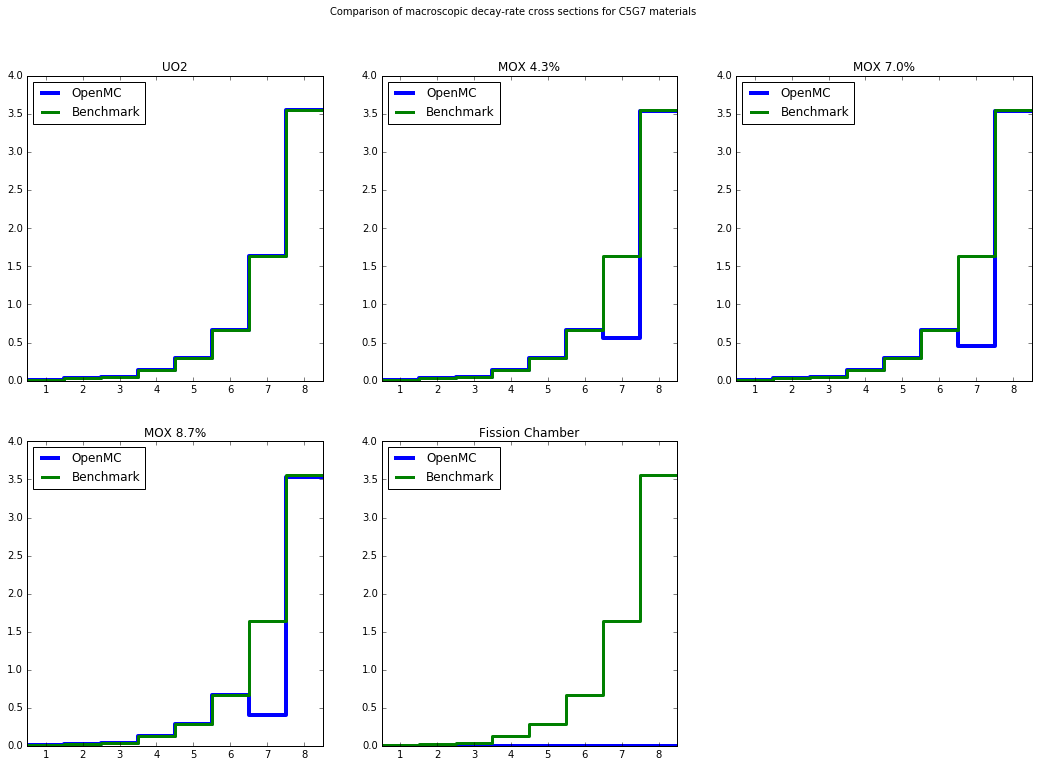

In [20]:
xs = 'decay-rate'
xs_cells = ['UO2', 'MOX 4.3%', 'MOX 7.0%', 'MOX 8.7%', 'Fission Chamber']
ANL_xs = {}
ANL_mgxs = {}
c5g7_xs = {}

one_group = openmc.mgxs.EnergyGroups()
one_group.group_edges = [0., 2.0e7]

for cell in xs_cells:
    ANL_mgxs[cell] = None

# Retrieve the fission xs for the fissile materials in the geometry.
for domain in ANL_lib.domains:
    for cell in xs_cells:
        if cell == 'Moderator':
            if cell in domain.name:
                if ANL_mgxs[cell] is None:
                    ANL_mgxs[cell] = ANL_lib.get_mgxs(domain, xs).get_condensed_xs(one_group)
                else:
                    ANL_mgxs[cell] = ANL_mgxs[cell].get_homogenized_mgxs(ANL_lib.get_mgxs(domain, xs).get_condensed_xs(one_group))
        elif 'Moderator' not in domain.name:
            if cell in domain.name:
                if ANL_mgxs[cell] is None:
                    ANL_mgxs[cell] = ANL_lib.get_mgxs(domain, xs).get_condensed_xs(one_group)
                else:
                    ANL_mgxs[cell] = ANL_mgxs[cell].get_homogenized_mgxs(ANL_lib.get_mgxs(domain, xs).get_condensed_xs(one_group))

for cell in xs_cells:
    ANL_xs[cell] = ANL_mgxs[cell].get_xs()
    ANL_xs[cell] = np.append(ANL_xs[cell], ANL_xs[cell][-1])
    c5g7_xs[cell] = np.append(mgxs_data[cell][xs], mgxs_data[cell][xs][-1])
        
matplotlib.rcParams.update({'font.size': 10})
ncols = 3
nrows = int(np.ceil(float(len(xs_cells)) / ncols))
fig = plt.figure(figsize=(18,6*nrows))
plt.suptitle('Comparison of macroscopic {} cross sections for C5G7 materials'.format(xs))

for i,cell in enumerate(xs_cells):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.step(np.arange(0.5,9.5), ANL_xs[cell], where='post', linewidth=4)
    plt.step(np.arange(0.5,9.5), c5g7_xs[cell], where='post', linewidth=3)
    plt.legend(['OpenMC', 'Benchmark'], loc='best')
    if xs in ['chi-delayed', 'beta', 'decay-rate']:
        ax.set_yscale("linear", nonposy='clip')
        ax.set_xscale("linear", nonposx='clip')
        plt.xlim([0.5,8.5])
    else:
        ax.set_yscale("log", nonposy='clip')
        ax.set_xscale("log", nonposx='clip')
    plt.title(cell)